In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

import itertools

tf.keras.backend.clear_session()
tf.__version__

'2.0.0'

In [2]:
# Radial basis activation function: e^(-x^2)
@tf.function
def rbf(x):
    return tf.exp(-tf.pow(x, 2))

In [3]:
model = keras.models.Sequential([
    keras.layers.Dense(1,
                       use_bias=False,
                       input_shape=(2,),
                       activation=rbf)
])
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

<tf.Variable 'UnreadVariable' shape=(2, 1) dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [4]:
#model.compile(loss="mse", optimizer="sgd", metrics=["binary_accuracy"])
model.compile(loss="mse", optimizer="sgd", metrics=["accuracy"])

In [5]:
y = np.array([
    1,
    1,
    0,
    0
])
x = np.array([
    (0, 0),
    (2, 2),
    (2, 0),
    (0, 2)
])
x, y

(array([[0, 0],
        [2, 2],
        [2, 0],
        [0, 2]]), array([1, 1, 0, 0]))

In [6]:
def compute_subgoals(initial, goal, N, model, x):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return model.predict(x)

    subgoal_weights = tf.expand_dims(tf.linspace(0., 1, N), axis=-1) * (goal - initial) + initial

    subgoals = tf.stack([predict_for_weights(weights, x) for weights in subgoal_weights])
    subgoals = tf.squeeze(subgoals)
    
    return subgoal_weights, subgoals


initial = tf.constant([1., 1])
goal = tf.constant([1., -1])
N = 10 # number of subgoals

weights, subgoals = compute_subgoals(initial, goal, N, model, x)
subgoals

<tf.Tensor: id=787, shape=(10, 4), dtype=float32, numpy=
array([[1.00000000e+00, 1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.00000000e+00, 3.23340305e-06, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 6.25832836e-05, 1.83156393e-02, 2.90960431e-01],
       [1.00000000e+00, 8.15988577e-04, 1.83156393e-02, 6.41180396e-01],
       [1.00000000e+00, 7.16697238e-03, 1.83156393e-02, 9.51816797e-01],
       [1.00000000e+00, 4.24048156e-02, 1.83156393e-02, 9.51816738e-01],
       [1.00000000e+00, 1.69013351e-01, 1.83156393e-02, 6.41180336e-01],
       [1.00000000e+00, 4.53788817e-01, 1.83156393e-02, 2.90960431e-01],
       [1.00000000e+00, 8.20754826e-01, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 1.00000000e+00, 1.83156393e-02, 1.83156393e-02]],
      dtype=float32)>

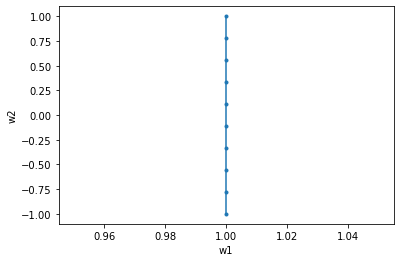

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

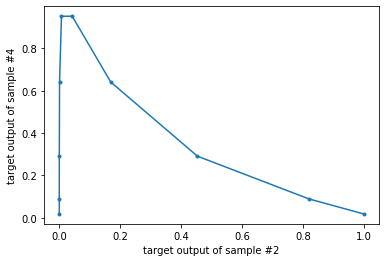

In [24]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 1], subgoals[..., 3], '.-')

In [16]:
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))


def has_achieved(model, x, subgoals, i):
    #print(tf.norm(tf.squeeze(model.predict(x)) - subgoals[i]), tf.norm(subgoals[i-1] - subgoals[i]))
    return tf.norm(tf.squeeze(model.predict(x)) - subgoals[i]) <= .5 * tf.norm(subgoals[i-1] - subgoals[i])

class EarlyStoppingOnSubgoal(tf.keras.callbacks.Callback):
    def __init__(self, x, subgoals, i):
        self.x = x
        self.subgoals = subgoals
        self.i = i
    
    def on_epoch_end(self, epoch, logs=None):
        if has_achieved(self.model, self.x, self.subgoals, self.i):
            self.model.stop_training = True
            print(f"stopping after {epoch} epochs")

loss = []
for i in range(1, len(subgoals)):
    print(f"attempting to achieve subgoal #{i}")
    history = model.fit(x, subgoals[i],
                        batch_size=len(subgoals[i]),
                        epochs=5000,
                        callbacks=[EarlyStoppingOnSubgoal(x, subgoals, i)],
                        verbose=0)
    loss.append(history.history["loss"])

attempting to achieve subgoal #1
stopping after 2258 epochs
attempting to achieve subgoal #2
stopping after 388 epochs
attempting to achieve subgoal #3
stopping after 101 epochs
attempting to achieve subgoal #4
stopping after 82 epochs
attempting to achieve subgoal #5
attempting to achieve subgoal #6
attempting to achieve subgoal #7
attempting to achieve subgoal #8
attempting to achieve subgoal #9


Text(0, 0.5, 'Loss')

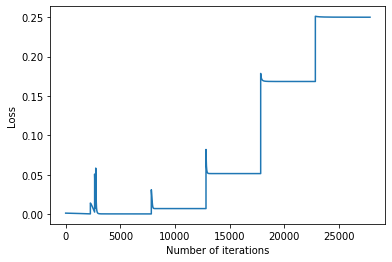

In [22]:
loss_values = list(itertools.chain(*loss))

fig, ax = plt.subplots()
ax.plot(loss_values)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")

In [25]:
model.get_weights()

[array([[0.9895827],
        [0.9510139]], dtype=float32)]

In [27]:
weights[-1]

<tf.Tensor: id=3702508, shape=(2,), dtype=float32, numpy=array([ 1., -1.], dtype=float32)>